# Code to analyse BC sensation levels at 65 dB with signal in front (0 degrees)

27-12-2020 Guido Cattani

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mannwhitneyu

In [2]:
# read difference sensation levels BC - AC measured with a 65 dB ISDS input signal in front (0 degrees)
def read_diff_sl_65_0():
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Headband/SL_BC.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, engine='openpyxl', sheet_name='BC_SL_65dB_0deg', header=0, nrows=85)
    df = df.drop(['Unnamed: 0'], axis=1)
    df = df.fillna(pd.NA)
    return df

In [3]:
# adjust column names, change format columns labels 'f_Hz' to f

data = read_diff_sl_65_0()
clmns = data.columns
l = list()
for clm in clmns:
    l.append(clm)
l = l[2:]
l2 = list()
for s in l:
    s = s.rstrip('_Hz')
    f = int(s)
    l2.append(f)
d = dict()
d1 = dict()
for i in range(len(l)):
    d.update({l[i] : l2[i]})
    d1.update({l2[i] : l[i]})

data1 = data.drop(columns='Study_ID') # drop first column
data1 = data1.rename(columns=d)
data1 = data1.dropna(axis='index')
type_device = data1.pop('Device')
data1 = data1.astype('int64')
data1.insert(0, 'Device', type_device)

In [4]:
data1

,Device,125,160,200,250,315,400,500,630,800,1000,1250,1600,2000,2500,3150,4000,5000,6300,8000
0,BP110,-16,-16,-16,-16,-9,-3,0,11,17,16,8,4,1,0,3,5,0,-3,-14
1,BP110,-21,-21,-21,-21,-16,-11,-4,11,20,22,30,36,20,2,-10,-33,-40,-45,-56
5,BP110,-12,-12,-12,-12,-2,5,13,25,31,30,28,28,24,20,21,13,8,4,-6
9,BP110,-19,-19,-19,-19,-7,1,10,24,33,33,34,34,18,9,2,-7,-12,-16,-26
11,BP110,-25,-25,-25,-25,-10,3,15,27,34,33,26,21,13,9,8,2,-3,-8,-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,BAHA5P,-35,-35,-35,-35,-35,-26,-15,4,18,27,20,16,20,17,18,3,-3,-10,-24
81,BAHA5P,-24,-24,-24,-24,-25,-20,-12,2,8,10,14,21,26,20,16,6,0,-4,-17
82,BAHA5P,-29,-29,-29,-29,-25,-14,1,13,17,17,29,37,28,17,9,-1,-7,-12,-25
83,BAHA5P,-34,-34,-34,-34,-33,-25,-15,4,17,25,21,17,8,-4,-12,-10,-17,-23,-37


In [5]:
# group data by device type and perform calculation of quantiles 10, 50, 90
dvc = data1.groupby('Device')
quantiles = [0.10, 0.50, 0.90]
q = dvc.quantile(q=quantiles)

# convert Pandas object in numpy array
frqc = np. array(l2 , dtype=int)
p10_bh5 = q.iloc[0].T.to_numpy()
median_bh5 = q.iloc[1].T.to_numpy()
p90_bh5 = q.iloc[2].T.to_numpy()
p10_bp110 = q.iloc[3].T.to_numpy()
median_bp110 = q.iloc[4].T.to_numpy()
p90_bp110 = q.iloc[5].T.to_numpy()

# select BP110 data and convert the Pandas Dataframe to numpy array
is_bp110 =  data1['Device']=='BP110'
output_bp110 = data1[is_bp110]
dvc1 = output_bp110.pop('Device')
bp110 = output_bp110.T.to_numpy()

# select BAHA5P data and convert the Pandas Dataframe to numpy array
is_baha5p =  data1['Device']=='BAHA5P'
output_baha5p = data1[is_baha5p]
dvc2 = output_baha5p.pop('Device')
bh5 = output_baha5p.T.to_numpy()

In [6]:
len(output_bp110)

35

In [7]:
len(output_baha5p)

35

In [8]:
# select data columns for violin plot with frequency 1 - 8 kHz  and convert data to numpy arrays

output_bp110_hf = output_bp110.drop(columns =[125, 160, 200, 250, 315, 400, 500, 630, 800]) 
output_baha5p_hf = output_baha5p.drop(columns =[125, 160, 200, 250, 315, 400, 500, 630, 800]) 
bp110_hf = output_bp110_hf.to_numpy()
bh5_hf = output_baha5p_hf.to_numpy()

In [9]:
# compare distribution output BAHA5P vs. BP110 with Mann Whitney U test

mwu = dict()

for i in range(0, 19):
    a = output_baha5p.iloc[:, i]
    b = output_bp110.iloc[:, i]
    f = l2[i]
    # scipy.stats mannwhitneyu test
    u_statistic, pVal = mannwhitneyu(a , b, use_continuity=False, alternative='two-sided') 
    pVal = round(pVal, 15)
    st = {f: [u_statistic, pVal]}
    mwu.update(st)
u_test = pd.DataFrame.from_dict(mwu, dtype='float')

In [10]:
u_test

,125,160,200,250,315,400,500,630,800,1000,1250,1600,2000,2500,3150,4000,5000,6300,8000
0,293.000000,293.000000,293.000000,293.000000,6.100000e+01,8.000000e+01,258.00000,269.000000,269.500000,351.500000,614.50000,795.500000,920.0000,962.00000,952.500000,904.500000,866.500000,857.500000,804.000000
1,0.000169,0.000169,0.000169,0.000169,8.970200e-11,3.878340e-10,0.00003,0.000053,0.000055,0.002143,0.98123,0.031369,0.0003,0.00004,0.000064,0.000598,0.002826,0.003986,0.024281


In [11]:
# join percentiles & U-test and present both in table

q= q.round(decimals=0)
q = q.reset_index()
diq = {0:'BAHA5P P10', 1:'BAHA5P P50', 2:'BAHA5P P90', 
      3:'BP110 P10', 4:'BP110 P50', 5:'BP110 P90'} 

q = q.rename(index=diq)
q = q.drop(['Device', 'level_1'], axis=1)

diu =  {0: 'Mann-Whitney U statistic', 1: 'p-value (two-sided)'}
u_test = u_test.rename(index=diu)

analysis_output = pd.concat([q, u_test])

analysis_output = analysis_output.rename(columns=d1)

# write to xlsx file
analysis_output.to_excel("/media/guido/LACIE/Cingle_Guido/Analysis_results/analysis_BC_sl_65dB_in_front.xlsx",
                         sheet_name='Output_BAHA5_vs_BP110')  

analysis_output

,125_Hz,160_Hz,200_Hz,250_Hz,315_Hz,400_Hz,500_Hz,630_Hz,800_Hz,1000_Hz,1250_Hz,1600_Hz,2000_Hz,2500_Hz,3150_Hz,4000_Hz,5000_Hz,6300_Hz,8000_Hz
BAHA5P P10,-35.000000,-35.000000,-35.000000,-35.000000,-3.400000e+01,-2.500000e+01,-13.00000,2.000000,9.000000,10.000000,15.00000,16.000000,13.0000,7.00000,2.000000,-8.000000,-14.000000,-18.000000,-31.000000
BAHA5P P50,-29.000000,-29.000000,-29.000000,-29.000000,-2.600000e+01,-1.800000e+01,-3.00000,10.000000,18.000000,23.000000,25.00000,29.000000,22.0000,17.00000,15.000000,10.000000,1.000000,-3.000000,-16.000000
BAHA5P P90,-22.000000,-22.000000,-22.000000,-22.000000,-1.800000e+01,-1.000000e+01,5.00000,18.000000,26.000000,27.000000,32.00000,36.000000,31.0000,24.00000,25.000000,22.000000,16.000000,13.000000,-0.000000
BP110 P10,-30.000000,-30.000000,-30.000000,-30.000000,-2.000000e+01,-1.100000e+01,-3.00000,9.000000,16.000000,12.000000,11.00000,7.000000,2.0000,0.00000,-9.000000,-25.000000,-30.000000,-34.000000,-45.000000
BP110 P50,-24.000000,-24.000000,-24.000000,-24.000000,-1.200000e+01,-3.000000e+00,5.00000,18.000000,27.000000,27.000000,25.00000,22.000000,14.0000,8.00000,3.000000,1.000000,-4.000000,-9.000000,-20.000000
BP110 P90,-13.000000,-13.000000,-13.000000,-13.000000,-4.000000e+00,5.000000e+00,16.00000,28.000000,35.000000,36.000000,32.00000,34.000000,25.0000,15.00000,15.000000,10.000000,5.000000,2.000000,-8.000000
Mann-Whitney U statistic,293.000000,293.000000,293.000000,293.000000,6.100000e+01,8.000000e+01,258.00000,269.000000,269.500000,351.500000,614.50000,795.500000,920.0000,962.00000,952.500000,904.500000,866.500000,857.500000,804.000000
p-value (two-sided),0.000169,0.000169,0.000169,0.000169,8.970200e-11,3.878340e-10,0.00003,0.000053,0.000055,0.002143,0.98123,0.031369,0.0003,0.00004,0.000064,0.000598,0.002826,0.003986,0.024281


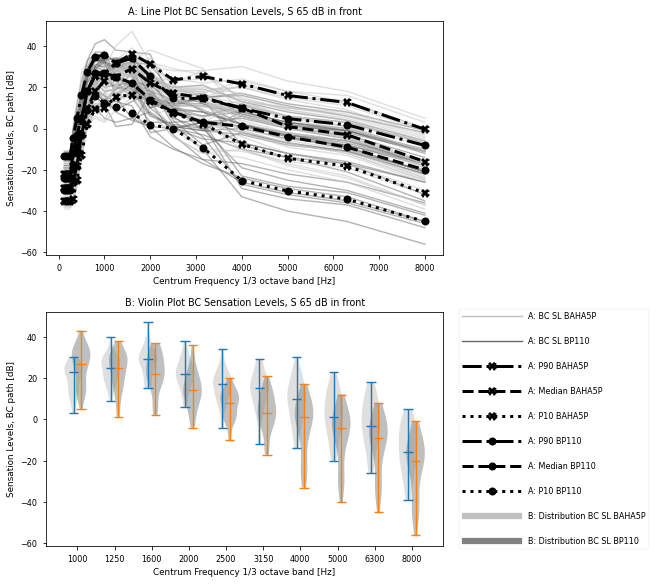

In [12]:
# make a figure to plot otput baha5 vs. BP110

plt.style.use('seaborn-paper')
plt.rcParams['axes.facecolor'] = 'white'

fig, (ax, ax1) = plt.subplots(2, constrained_layout=True)

fig.set_figheight(8)
fig.set_figwidth(9)


# make the line plot

ax.set(xlabel='Centrum Frequency 1/3 octave band [Hz]', ylabel='Sensation Levels, BC path [dB]',
       title='A: Line Plot BC Sensation Levels, S 65 dB in front')

# plot lines based on numpy arrays
ax.plot(frqc, bp110, color="dimgrey", alpha=0.5, label='Difference SL BP110')
ax.plot(frqc, bh5, color="silver", alpha=0.5, label='Difference SL BAHA5P')
ax.plot(frqc, median_bp110, color='black', marker='o', linestyle='dashed', linewidth=3, markersize=8)
ax.plot(frqc, p10_bp110, color='black', marker='o', linestyle='dotted', linewidth=3, markersize=8)
ax.plot(frqc, p90_bp110, color='black', marker='o', linestyle='dashdot', linewidth=3, markersize=8)
ax.plot(frqc, median_bh5, color='black', marker='X', linestyle='dashed', linewidth=3, markersize=9)
ax.plot(frqc, p10_bh5, color='black', marker='X', linestyle='dotted', linewidth=3, markersize=9)
ax.plot(frqc, p90_bh5, color='black', marker='X', linestyle='dashdot', linewidth=3, markersize=9)


# make the violin plot

xi = list(range(1, 11))
x = list(output_bp110_hf.columns)


ax1.set(xlabel='Centrum Frequency 1/3 octave band [Hz]', ylabel='Sensation Levels, BC path [dB]', 
        title='B: Violin Plot BC Sensation Levels, S 65 dB in front')

ax1.set_xticks(xi)
ax1.set_xticklabels(x)

viol1 = ax1.violinplot(bh5_hf, positions=[0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9], 
                       showmeans=False, showmedians=True, showextrema=True)

for pc in viol1['bodies']:
    pc.set_facecolor('silver')
    pc.set_alpha(0.5)


viol2 = ax1.violinplot(bp110_hf, positions=[1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1], 
                       showmeans=False, showmedians=True, showextrema=True)

for pc in viol2['bodies']:
    pc.set_facecolor('grey')
    pc.set_alpha(0.5)

    
# make a legend
leg_line_BH5 = mlines.Line2D([], [], color="silver", label='A: BC SL BAHA5P')
leg_line_BP110 = mlines.Line2D([], [], color="dimgrey", label='A: BC SL BP110')

leg_p90_bh5 = mlines.Line2D([], [], color='black', marker='X', linestyle='dashdot', 
                            linewidth=3, markersize=9, label='A: P90 BAHA5P')
leg_med_bh5 = mlines.Line2D([], [], color='black', marker='X', linestyle='dashed', 
                            linewidth=3, markersize=9, label='A: Median BAHA5P')
leg_p10_bh5 = mlines.Line2D([], [], color='black', marker='X', linestyle='dotted', 
                            linewidth=3, markersize=9, label='A: P10 BAHA5P')
leg_p90_bp110 = mlines.Line2D([], [], color='black', marker='o', linestyle='dashdot', 
                              linewidth=3, markersize=8, label='A: P90 BP110')
leg_med_bp110 = mlines.Line2D([], [], color='black', marker='o', linestyle='dashed', 
                              linewidth=3, markersize=8, label='A: Median BP110')
leg_p10_bp110 = mlines.Line2D([], [], color='black', marker='o', linestyle='dotted', 
                              linewidth=3, markersize=8, label='A: P10 BP110')
leg_patch_BH5 = mpatches.Patch(color="silver", label='B: Distribution BC SL BAHA5P')
leg_patch_BP110 = mpatches.Patch(color="grey", label='B: Distribution BC SL BP110')      

leg = plt.legend(handles=[leg_line_BH5, leg_line_BP110, leg_p90_bh5, leg_med_bh5, leg_p10_bh5, leg_p90_bp110, 
                        leg_med_bp110, leg_p10_bp110, leg_patch_BH5, leg_patch_BP110], 
                 bbox_to_anchor=(1.03, 1.03), loc='upper left', labelspacing=2., handlelength=7.5)


# save figure to file
plt.savefig('/media/guido/LACIE/Cingle_Guido/Analysis_results/BC_sl_S65_in_front.tiff', 
           transparent=False, dpi=500, bbox_inches="tight")

plt.show() # show the figure